In [1]:
""" LSTM prediction: stacked LSTM """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('data_hr - data_hr.csv', encoding='utf-8')

In [3]:
print(data)

                    date       dam   90  100  101  211  212
0        1997-01-01 0:00     0.000  0.0  0.3  0.0  0.3  0.0
1        1997-01-01 1:00     0.000  0.0  0.0  0.0  0.0  0.0
2        1997-01-01 2:00     0.000  0.0  0.0  0.0  0.0  0.0
3        1997-01-01 3:00  2000.000  0.0  0.0  0.0  0.0  0.0
4        1997-01-01 4:00     0.000  0.0  0.0  0.0  0.0  0.0
...                  ...       ...  ...  ...  ...  ...  ...
236659  2023-12-31 19:00   173.106  0.0  0.0  0.0  0.0  0.0
236660  2023-12-31 20:00     0.000  0.0  0.0  0.0  0.0  0.0
236661  2023-12-31 21:00   124.118  0.0  0.0  0.0  0.0  0.0
236662  2023-12-31 22:00    15.417  0.0  0.0  0.0  0.0  0.0
236663  2023-12-31 23:00     0.000  0.0  0.0  0.0  0.0  0.0

[236664 rows x 7 columns]


In [4]:
data = data.fillna(0)
data = data[26280:]
data = data.reset_index(drop=True, inplace=False)

In [5]:
original_dam = data['dam']

In [6]:
print(original_dam)

0          13.100
1           0.000
2           0.000
3         143.400
4           0.000
           ...   
210379    173.106
210380      0.000
210381    124.118
210382     15.417
210383      0.000
Name: dam, Length: 210384, dtype: float64


In [7]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [8]:
# variables for training
cols = list(data)[1:7]

In [9]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [10]:
data.dtypes

date     object
dam     float64
90      float64
100     float64
101     float64
211     float64
212     float64
dtype: object

In [11]:
# new dataframe with only training data - 6 columns
data = data[cols].astype(float)

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)

In [13]:
dam = data.drop(['90','100','101','211','212'], axis = 1)

In [14]:
scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [15]:
print(dam_data_scaled)

[[0.00123644 0.0011274  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 ...
 [0.01171487 0.         0.         0.         0.         0.        ]
 [0.00145513 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [16]:
print(dam_scaled)

[[0.00123644]
 [0.        ]
 [0.        ]
 ...
 [0.01171487]
 [0.00145513]
 [0.        ]]


In [17]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates)

189345   2021-08-07 09:00:00
189346   2021-08-07 10:00:00
189347   2021-08-07 11:00:00
189348   2021-08-07 12:00:00
189349   2021-08-07 13:00:00
                 ...        
210379   2023-12-31 19:00:00
210380   2023-12-31 20:00:00
210381   2023-12-31 21:00:00
210382   2023-12-31 22:00:00
210383   2023-12-31 23:00:00
Name: date, Length: 21039, dtype: datetime64[ns]


In [18]:
print(train_data_scaled[:25])

[[0.00123644 0.0011274  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.0135348  0.00789177 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.00631435 0.         0.00148588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.0076263  0.         0.         0.         0.         0.        ]
 [0.         0.         0.00148588 0.         0.         0.        ]
 [0.0013969  0.         0.         0.         0.         0.        ]
 [0.00756023 0.         0.         0.         0.         0.        ]
 [0.         0.         0.00594354 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.        

In [19]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 72   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days , 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [20]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(189273, 72, 6) (189273, 1)
(20967, 72, 6) (20967, 1)


In [21]:
print(trainX[:2], trainY[0])

[[[0.00123644 0.0011274  0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.0135348  0.00789177 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.00631435 0.         0.00148588 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.0076263  0.         0.         0.         0.         0.        ]
  [0.         0.         0.00148588 0.         0.         0.        ]
  [0.0013969  0.         0.         0.         0.         0.        ]
  [0.00756023 0.         0.         0.         0.         0.        ]
  [0.         0.         0.00594354 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.    

In [22]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30

5324/5324 [==============================] - 145s 27ms/step - loss: 4.4901e-04 - val_loss: 1.1829e-04
Epoch 2/30
5324/5324 [==============================] - 141s 26ms/step - loss: 1.5690e-04 - val_loss: 1.5081e-04
Epoch 3/30
5324/5324 [==============================] - 141s 26ms/step - loss: 1.3200e-04 - val_loss: 1.1036e-04
Epoch 4/30
5324/5324 [==============================] - 142s 27ms/step - loss: 1.2284e-04 - val_loss: 1.6007e-04
Epoch 5/30
5324/5324 [==============================] - 141s 26ms/step - loss: 4.9045e-04 - val_loss: 2.4988e-04
Epoch 6/30
5324/5324 [==============================] - 142s 27ms/step - loss: 3.3993e-04 - val_loss: 0.0022
Epoch 7/30
5324/5324 [==============================] - 142s 27ms/step - loss: 2.8848e-04 - val_loss: 6.4639e-04
Epoch 8/30
5324/5324 [==============================] - 137s 26ms/step - loss: 3.2807e-04 - val_loss: 5.3010e-04
Epoch 9/30
5324/5324 [==============================]

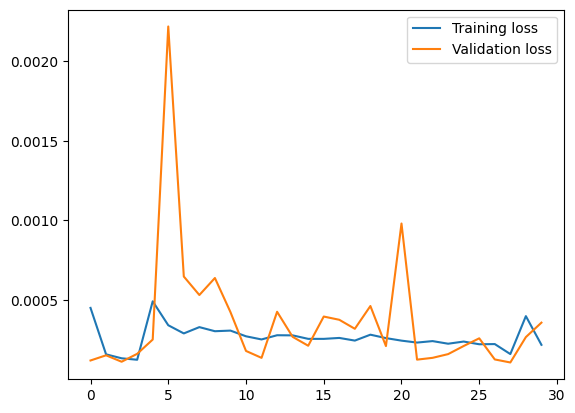

In [24]:
# Try to load weights
try:
    model.load_weights('72hr_dam_lstm_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('72hr_dam_lstm_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [25]:
# generate array filled with means for prediction
# mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# # substitute predictions into the first column
# mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
# y_pred = scaler_dam.inverse_transform(prediction)[:,0]

# # generate array filled with means for testY
# mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# # substitute testY into the first column
# mean_values_testY[:, 0] = np.squeeze(testY)

656/656 [==============================] - 11s 14ms/step
(20967, 1) (20967, 1)


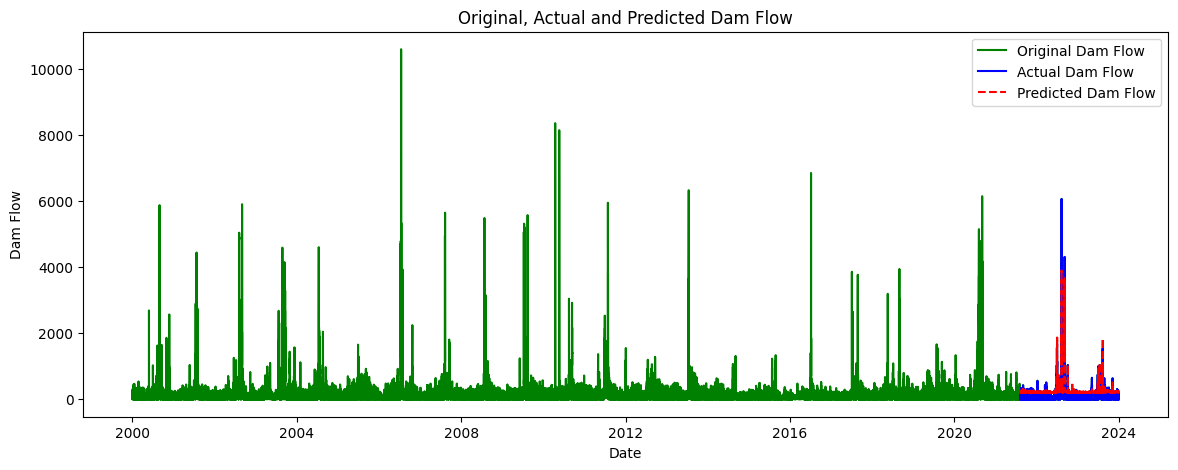

In [26]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]
testY_original = scaler_dam.inverse_transform(testY)[:,0]

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [27]:
testDates = pd.DataFrame(test_dates[48:])
testDates = testDates.reset_index(drop=True)
pred_y = pd.DataFrame(y_pred)
origin_y = pd.DataFrame(testY_original)

print(len(testDates), len(pred_y), len(origin_y))

lstm_include_dam = pd.concat([testDates, origin_y, pred_y], axis = 1)
print(lstm_include_dam)

# lstm_include_dam = pd.DataFrame(lstm_include_dam)
# lstm_include_dam.to_csv("hr_lstm_include_dam.csv")

20991 20967 20967
                     date        0           0
0     2021-08-09 09:00:00    1.493  235.799835
1     2021-08-09 10:00:00  204.139  227.403320
2     2021-08-09 11:00:00   71.500  229.172806
3     2021-08-09 12:00:00   71.533  222.973938
4     2021-08-09 13:00:00   71.449  229.662216
...                   ...      ...         ...
20986 2023-12-31 19:00:00      NaN         NaN
20987 2023-12-31 20:00:00      NaN         NaN
20988 2023-12-31 21:00:00      NaN         NaN
20989 2023-12-31 22:00:00      NaN         NaN
20990 2023-12-31 23:00:00      NaN         NaN

[20991 rows x 3 columns]


In [28]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

print(testX_last)

#lstm_include_x = pd.concat([testDates, testX_last,origin_y,pred_y], axis = 1)
#lstm_include_x.to_csv("data/hr_lstm_include_x.csv")

[0.01256896 0.         0.         0.         0.         0.        ]
             0    1    2    3    4    5
0      133.167  0.0  0.0  0.0  0.0  0.0
1        1.493  0.0  0.0  0.0  0.0  0.0
2      204.139  0.0  0.0  0.0  0.0  0.0
3       71.500  0.0  0.0  0.0  0.0  4.2
4       71.533  0.0  0.0  0.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...
20962   21.177  1.6  0.0  0.0  0.0  0.0
20963  173.106  0.0  0.0  0.0  0.0  0.0
20964    0.000  0.0  0.0  0.0  0.0  0.0
20965  124.118  0.0  0.0  0.0  0.0  0.0
20966   15.417  0.0  0.0  0.0  0.0  0.0

[20967 rows x 6 columns]


In [29]:
# original_data = pd.DataFrame(testY_original)
# prediction_data = pd.DataFrame(y_pred)

# print(original_data)
# print(prediction_data)

# result = pd.concat([original_data,prediction_data],axis=1)
# result.to_csv("/content/drive/MyDrive/240410/result.csv")

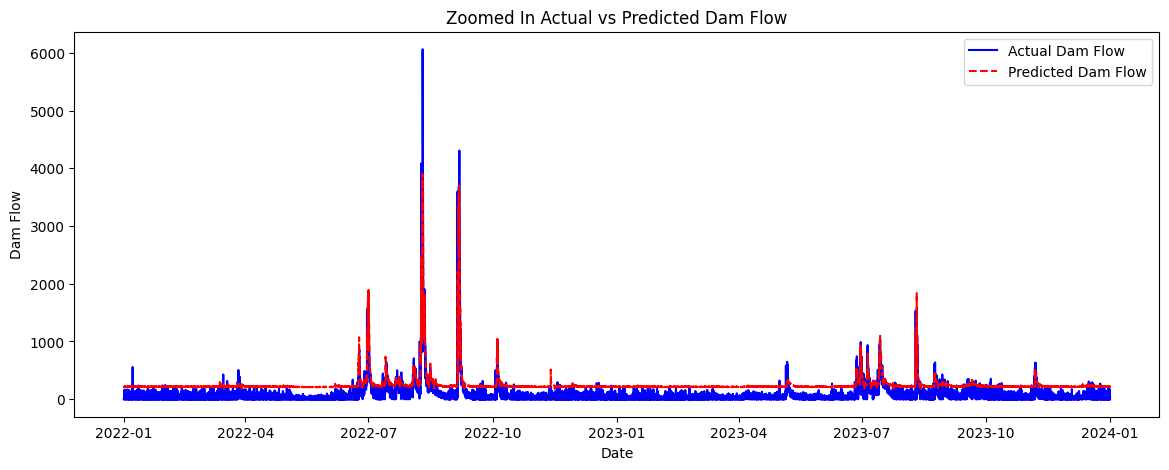

In [30]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*24*2
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

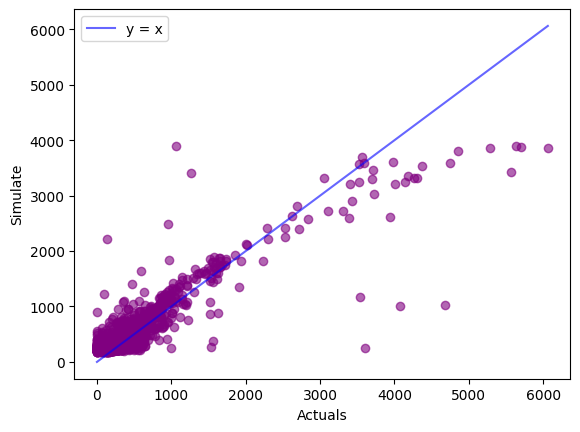

In [31]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [32]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

RMSE : 192.68
NSE : 0.201999
PBIAS : -209.162435
R Square : 0.507313
